## EDA

In [1]:
import os
import pandas as pd

from glob import glob

In [2]:
path = './train'

In [3]:
label_list = os.listdir(path)
label_list

['dog',
 'elephant',
 'giraffe',
 'guitar',
 'horse',
 'house',
 'person',
 'train.csv']

In [4]:
data = {
    'image_id': [], 
    'label': []
}

In [5]:
for i, v in enumerate(label_list):
  file_list = glob(os.path.join(path, v) + '/*.jpg')
  data['image_id'].extend(file_list)
  data['label'].extend([i for _ in range(len(file_list))])

In [6]:
print(len(data['image_id']))
print(len(data['label']))

1698
1698


In [7]:
train_df = pd.DataFrame(data)
train_df.head(5)

,image_id,label
0,./train\dog\pic_001.jpg,0
1,./train\dog\pic_002.jpg,0
2,./train\dog\pic_003.jpg,0
3,./train\dog\pic_004.jpg,0
4,./train\dog\pic_005.jpg,0


In [8]:
train_df.to_csv(os.path.join(path, 'train.csv'), index=False)

In [9]:
import cv2
import torch
import albumentations
import albumentations.pytorch

from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_id']
        image = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

        if self.transform:
          image = self.transform(image=image)['image']
        return image

    def __len__(self):
        return len(self.df)

In [10]:
transform = albumentations.Compose([
  albumentations.Resize(height=227, width=227),
  albumentations.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
  albumentations.pytorch.transforms.ToTensorV2()
])

In [11]:
image_dataset = TrainDataset(df=train_df, transform=transform)
image_loader = DataLoader(image_dataset, 
                          batch_size  = 1, 
                          shuffle     = False)

In [12]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

In [13]:
from tqdm import tqdm

for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:05<00:00, 332.10it/s]


In [14]:
# Caculate mean and std

# pixel count
count = len(train_df) * 227 * 227

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.4569, 0.5074, 0.5557])
std:  tensor([0.2888, 0.2743, 0.2829])


C:\Users\KHJ\Anaconda3\envs\ustage\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


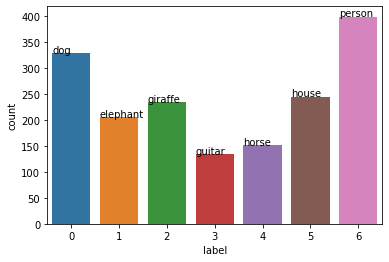

In [15]:
import matplotlib as pyplot
import seaborn as sns

ax = sns.countplot(train_df['label'])

for p, label in zip(ax.patches, label_list):
    ax.annotate(label, (p.get_x(), p.get_height() + 0.15))